## Email Classification (Spam vs Ham)
Goal:
Classify emails into Spam or Ham (non-spam) using a machine learning classifier trained on text data.
### Learning Objectives:
By the end of this activity, you will be able to:

<ol><li>Preprocess textual data, including tokenization and vectorization.
<li>Build and train a machine learning classifier for text classification.
<li>Evaluate the model using accuracy, precision, recall, and confusion matrix.
<li>Apply Natural Language Processing (NLP) techniques to handle real-world text data. </ol>

Dataset: SpamAssasin Dataset

### Step 1:
1. Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package wordnet to /root/nltk_data...


### Step 2. Load and Explore the Dataset
You can use the SpamAssassin dataset from Kaggle.<br>
Each email should be labeled as spam or ham.

In [ ]:
import kagglehub
#import pandas as pd
import os

dataset_path = kagglehub.dataset_download("ganiyuolalekan/spam-assassin-email-classification-dataset")

# The CSV file is named 'spam_assassin.csv' - adjust if necessary
csv_file_name = 'spam_assassin.csv'  # Replace with actual CSV file name
file_path = os.path.join(dataset_path, csv_file_name)
#encoding="latin-1"
# Load dataset
df = pd.read_csv(file_path)
df = df[['text', 'target']]  # Extract the relevant columns
df.columns = ['email_text', 'label']  # Rename columns
print(df.head()) # This displays the first five rows in the dataset

                                          email_text  label
0  From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...      0
1  From gort44@excite.com Mon Jun 24 17:54:21 200...      1
2  From fork-admin@xent.com Mon Jul 29 11:39:57 2...      1
3  From dcm123@btamail.net.cn Mon Jun 24 17:49:23...      1
4  From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...      0


In [ ]:
print(df.tail())

                                             email_text  label
5791  From ilug-admin@linux.ie Mon Jul 22 18:12:45 2...      0
5792  From fork-admin@xent.com Mon Oct 7 20:37:02 20...      0
5793  Received: from hq.pro-ns.net (localhost [127.0...      1
5794  From razor-users-admin@lists.sourceforge.net T...      0
5795  From rssfeeds@jmason.org Mon Sep 30 13:44:10 2...      0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   email_text  5796 non-null   object
 1   label       5796 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.7+ KB


In [ ]:
df['label'].value_counts()

,count
label,
0,3900
1,1896


### Data Cleaning

In [ ]:
# Download the stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import string # Import the string module
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def Clean_text(text):
    text_list = []


    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #remove links

    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text, flags=re.MULTILINE) #remove email addresses

    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation

    text = ''.join([i for i in text if not i.isdigit()]) # remove digits

    stop_words = stopwords.words('english')
    words_list = [w for w in text.split() if w not in stop_words] # remove stop words

    words_list = [lemmatizer.lemmatize(w) for w in words_list] #lemmatization

    words_list = [stemmer.stem(w) for w in words_list] #Stemming
    text_list.append(' '.join(words_list))
    return text_list

In [ ]:
data = df.copy()
data['Clean_email'] = data['email_text'].apply(Clean_text)
data.head()

,email_text,label
0,[from mon jul returnpath deliveredto receiv lo...,0
1,[from mon jun returnpath deliveryd tue jun rec...,1
2,[from mon jul returnpath deliveredto receiv lo...,1
3,[from mon jun returnpath deliveryd mon jun rec...,1
4,[from mon aug returnpath deliveredto receiv lo...,0


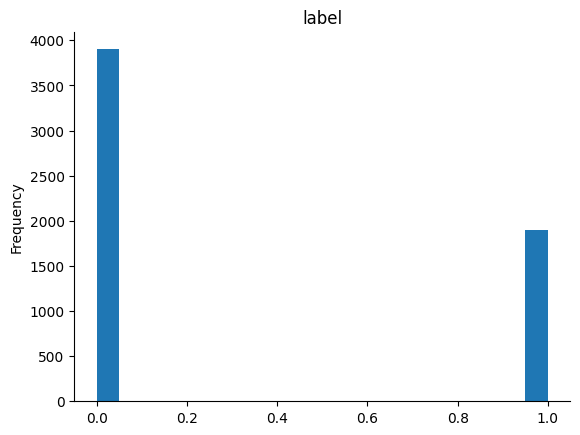

In [ ]:
# @title label

from matplotlib import pyplot as plt
data['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Data Visualization

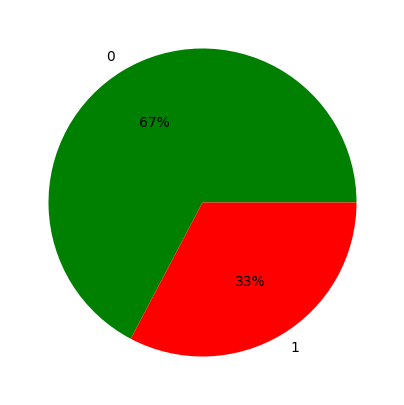

In [ ]:
counts = df['label'].value_counts()
labels = ['0', '1']
colors = ['green', 'red']
plt.figure(figsize=(12, 5))
plt.pie(counts, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()

<ipython-input-31-77aafb6df8f1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df['label'].value_counts(), palette=colors)


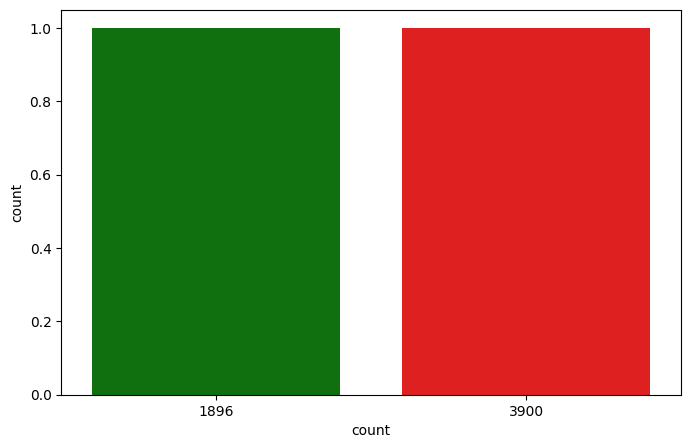

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x = df['label'].value_counts(), palette=colors)
plt.show()

### 3. Preprocess the Data
Convert the text data into numerical features using TF-IDF Vectorization.

In [ ]:
# Split dataset into training and test sets
X = data['email_text'].astype(str) # Convert the email_text column to string type
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, )

# Convert the stop_words set to a list
stop_words_list = list(stop_words)
# Use TF-IDF Vectorizer to convert text data into features
tfidf = TfidfVectorizer(stop_words=stop_words_list)

# Transform the training and testing data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


### 4. Train a Naive Bayes Classifier
Use the Multinomial Naive Bayes algorithm, which is suitable for text classification tasks.

In [ ]:
# Train Naive Bayes model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)


### 5. Evaluate the Model
<ul><li>Calculate the model's accuracy.
<li>Generate a classification report that includes precision, recall, and F1-score.
<li>Plot the confusion matrix to visualize the performance.

Accuracy: 0.928448275862069
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       779
           1       1.00      0.78      0.88       381

    accuracy                           0.93      1160
   macro avg       0.95      0.89      0.91      1160
weighted avg       0.94      0.93      0.93      1160



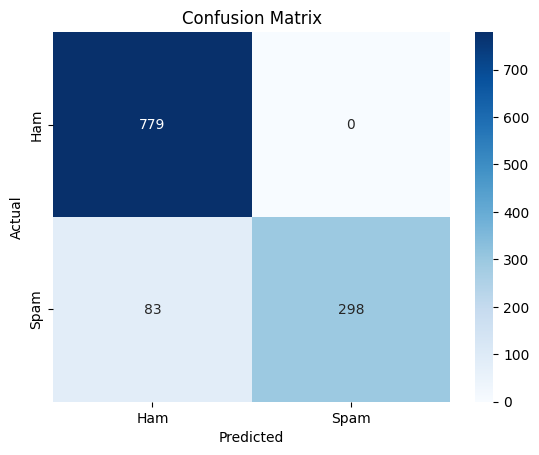

In [ ]:
# Evaluate model accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate and print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### 6. Model Interpretation and Discussion
Questions to discuss:
<ol>
<li>How well did the model perform?
<li>What could be improved (e.g., more data, better preprocessing)?
<li>Why is precision important in spam detection?
<li>How does Naive Bayes handle text data?

### Extension: Experiment with Other Models
You can extend this activity by:
<ul>
<li>Trying Logistic Regression or Support Vector Machines (SVM) for classification.
<li>Using n-grams in the TF-IDF vectorization to improve feature extraction.
<li>Performing cross-validation to improve model robustness.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Try Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

# Evaluate Logistic Regression
y_pred_lr = lr_model.predict(X_test_tfidf)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr)}")


Logistic Regression Accuracy: 0.9887931034482759
